In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots

Matplotlib is building the font cache; this may take a moment.


In [4]:
# operation on (uniform) random bits and registers

# coin with head probability alpha
def coin(alpha):
    return np.array([[alpha,alpha],[1-alpha,1-alpha]], dtype=float)
    
# flip with probability alpha
def flip(alpha):
    return np.array([[1-alpha,alpha],[alpha,1-alpha]], dtype=float)

# controlled not (if first register is 1, flip second register with probability alpha)
CNOT = np.array([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,0,1],
        [0,0,1,0]
         ], dtype=float)

# check if 2 bit state is product state (approximately)
def is_product(x):
    return abs(x[0] * x[3] - x[1] * x[2]) < 1e-15


def decompose_kronecker(x):
    # Check if x is a valid Kronecker product
    if not(is_product(x)):
        raise ValueError("Input state is not a product state.")
    
    # Choose a simple decomposition
    if x[0] != 0:
        a = [1.0, x[2] / x[0]]
        b = [x[0], x[1]]
    elif x[1] != 0:
        a = [1.0, x[3] / x[1]]
        b = [x[1], x[0]]
    else:
        # Degenerate case: all zeros
        a = [0.0, 0.0]
        b = [0.0, 0.0]
    
    return a, b

# sample (measure/observe)
def sample_reg(x):
    # Normalize probabilities
    x = np.array(x)
    x = x / x.sum()
    # Choose index based on probabilities
    idx = np.random.choice(range(len(x)), p=x)
    # Convert index to binary representation
    # Length = ceil(log2(len(x))) for fixed-width binary
    width = int(np.ceil(np.log2(len(x))))
    return [int(b) for b in format(idx, f'0{width}b')], idx

# simulate: sample nsmpls times and return empirical probabilities and binary labels
def simulate(x, n_samples = 10000):
    width = int(np.ceil(np.log2(len(x)))) if len(x) > 1 else 1

    # Collect samples
    results = np.zeros((n_samples, width), dtype=int)
    for i in range(n_samples):
        results[i, :] , _ = sample_reg(x)

    # Convert binary rows back to integers
    indices = np.array([int("".join(map(str, row)), 2) for row in results])

    # Compute empirical probabilities
    counts = np.bincount(indices, minlength=len(x))
    empirical_probs = counts / float(n_samples)

    # Binary labels
    binary_labels = [format(i, f'0{width}b') for i in range(len(x))]

    return empirical_probs, binary_labels

# Plot empirical vs theoretical probabilities with binary x-tick labels
def plot_probabilities(empirical_probs, theoretical_probs, binary_labels):
    xpos = np.arange(len(empirical_probs))
    fig, ax = plt.subplots(figsize=(7, 4.5))

    # Bars for empirical probabilities
    ax.bar(xpos, empirical_probs, align='center', edgecolor='black',
           color='#4e79a7', alpha=0.85, label='Empirical')

    # Overlay theoretical probabilities
    ax.plot(xpos, theoretical_probs, 'o-', color='#f28e2b',
            linewidth=2, label='Theoretical')

    # Cosmetics
    ax.set_xticks(xpos)
    ax.set_xticklabels(binary_labels)
    ax.set_xlabel('State')
    ax.set_ylabel('Probability')
    ax.set_title('Sampled probabilities')
    ax.set_ylim(0, max(empirical_probs.max(), theoretical_probs.max()) * 1.15)
    ax.grid(axis='y', alpha=0.2)
    ax.legend()

    # Add labels above bars
    for x, p in zip(xpos, empirical_probs):
        ax.text(x, p + 0.01, f'{p:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

[[0.36 0.36]
 [0.64 0.64]]
[0.36 0.64]
([1], np.int32(1))
[0.0045 0.0045]


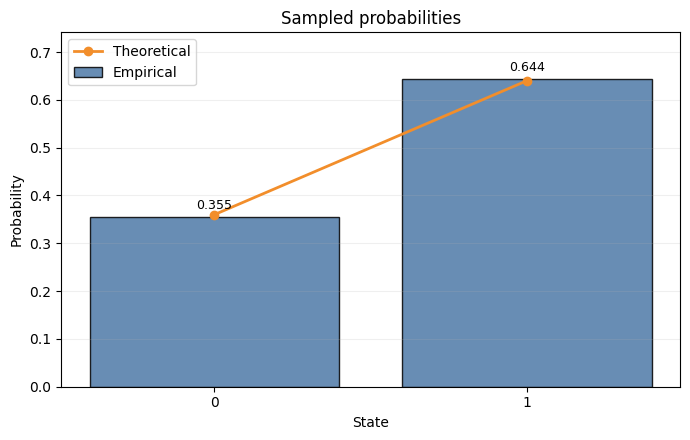

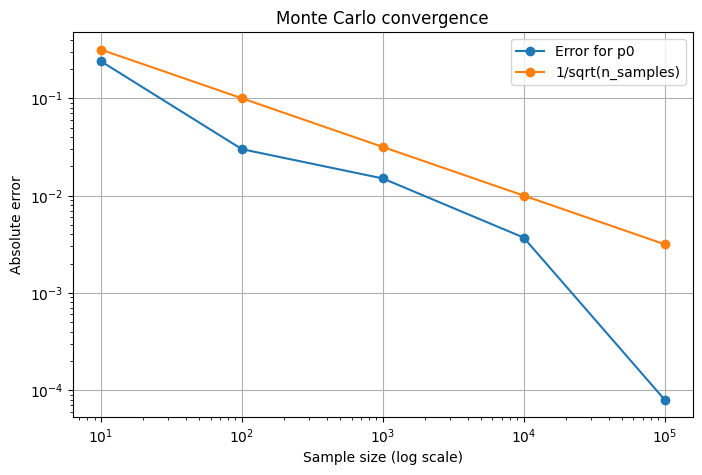

In [5]:
# Example 1.1
e0 = np.array([1,0])
S = coin(0.36)
print(S)
p = S @ e0
print(p)
print(sample_reg(p))

empirical_probs, binary_labels = simulate(p, n_samples=10000)
print(np.abs(empirical_probs-p))
plot_probabilities(empirical_probs, p, binary_labels)

# Sample sizes
sample_sizes = np.logspace(1, 5, num=5, dtype=int).tolist()

# Arrays to store errors
errors = []

# Generic for loop
for n in sample_sizes:
    empirical_probs , _ = simulate(p, n_samples = n)
    errors.append(np.abs(empirical_probs - p))

# Convert to array for plotting
errors = np.array(errors)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, errors[:, 0], marker='o', label='Error for p0')
plt.plot(sample_sizes, 1 / np.sqrt(sample_sizes), marker='o', label='1/sqrt(n_samples)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample size (log scale)')
plt.ylabel('Absolute error')
plt.title('Monte Carlo convergence')
plt.legend()
plt.grid(True)
plt.show()

[0.1296 0.2304 0.2304 0.4096]
True
[0.1296 0.2304 0.2304 0.4096]
[0.0008 0.0035 0.0012 0.0039]


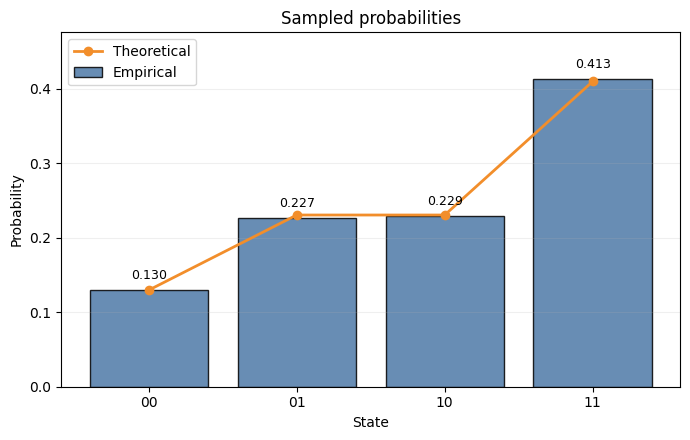

In [6]:
# # Example 1.2
pp = np.kron(p,p)
print(pp)
print(is_product(pp))
SS = np.kron(S,S)
e00 = np.kron(e0,e0)
print(SS @ e00)

empirical_probs, binary_labels = simulate(pp, n_samples=10000)
print(np.abs(empirical_probs-pp))
plot_probabilities(empirical_probs, pp, binary_labels)

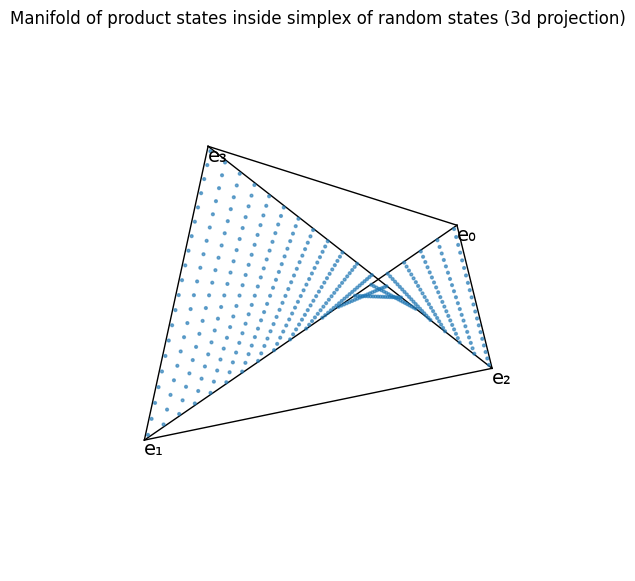

In [7]:
# Visualize state space and product states
v0 = np.array([1, 1, 1])
v1 = np.array([1, -1, -1])
v2 = np.array([-1, 1, -1])
v3 = np.array([-1, -1, 1])

V = np.vstack([v0, v1, v2, v3])

labels = ["e₀", "e₁", "e₂", "e₃"]

a_vals = np.linspace(0.01, 0.99, 20)
c_vals = np.linspace(0.01, 0.99, 20)
A, C = np.meshgrid(a_vals, c_vals)

X0 = A * C
X1 = A * (1 - C)
X2 = (1 - A) * C
X3 = (1 - A) * (1 - C)

pts = (
    X0[..., None] * v0 +
    X1[..., None] * v1 +
    X2[..., None] * v2 +
    X3[..., None] * v3
).reshape(-1, 3)

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=4, alpha=0.6)

edges = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
for i, j in edges:
    xs, ys, zs = zip(V[i], V[j])
    ax.plot(xs, ys, zs, color='black', linewidth=1)

for i, v in enumerate(V):
    ax.text(v[0], v[1], v[2], labels[i],
            fontsize=14, ha='left', va='top',
            color='black')

ax.set_title("Manifold of product states inside simplex of random states (3d projection)")
ax.set_axis_off()
ax.view_init(elev=15, azim=10)
plt.show()

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
[1. 0. 0. 0.]
([1.0, np.float64(0.0)], [np.float64(1.0), np.float64(0.0)])
[0.1296 0.2304 0.4096 0.2304]
False
[0.04243827 0.00694444 0.00292969 0.02560764]


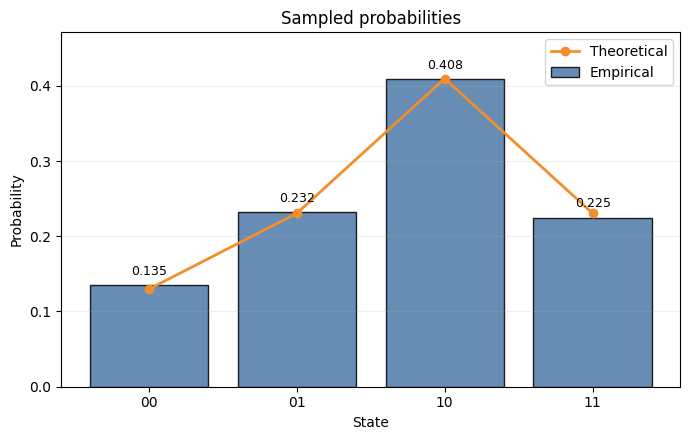

In [30]:
# Example 1.3
print(CNOT)
print(CNOT @ np.kron([1,0],[1,0]))
print(decompose_kronecker(CNOT @ np.kron([1,0],[1,0])))
x = CNOT @ pp
print(x)
print(is_product(x))

empirical_probs, binary_labels = simulate(x, n_samples=10000)
print(np.abs(empirical_probs-x)/np.abs(x))
plot_probabilities(empirical_probs, x, binary_labels)

In [31]:
# Example 1.4 - Monte Carlo integration

# Uniform single-bit stochastic gate
U = coin(0.5)

def kron_n(M, n):
    out = np.array([1.0])
    for _ in range(n):
        out = np.kron(out, M)
    return out

# Prepare (uniform random) m-bit register
def uniform_register(m):
    Ureg = kron_n(U, m)
    e0 = np.zeros(2**m); e0[0] = 1.0
    return Ureg @ e0   # probability vector on {0,...,2^m-1}


# Build stochastic matrix for indicator function
def indicator_operator(m, a, delta):
    M  = 2**m            # input register size
    N  = 2*M             # joint register size
    F  = np.zeros((N, N))

    mids = (np.arange(M) + 0.5) / M    # midpoints of discretisation

    for i, x in enumerate(mids):
        fout = 1 if (a <= x <= a + delta) else 0
        # basis states: input index i, output bit b ∈ {0,1}
        # column = i + b*M
        # output bit becomes fout, so row = i + fout*M
        for b in [0, 1]:
            col = i + b*M
            row = i + fout*M
            F[row, col] = 1.0
    return F

# Monte Carlo integration of indicator function of [a,a+delta], 0<=a<=a+delta<=1, delta << 1
def mc_indicator(m=8, n_samples=10000, a=0.33, delta=0.02):
    M = 2**m
    
    # prepare uniform input register inside joint register
    p = kron_n(U,m) @ kron_n(e0,m)
    p = np.kron(e0,p)
    
    # build indicator oracle
    F = indicator_operator(m, a, delta)

    # apply oracle: F(joint)
    out_dist = F @ p

    # measure n_samples times; extract output bit = floor(idx / M)
    hits = 0
    for _ in range(n_samples):
        _ , idx = sample_reg(out_dist)
        fout = idx // M
        hits += fout

    return hits / n_samples

# Run test
delta = 0.02
estimate = mc_indicator(m = 3 + np.int32(np.floor(np.abs(np.log(delta)))), n_samples = np.int32(np.floor(1000/delta)), delta = delta)
print(estimate)
print(np.abs(delta-estimate)/delta)

0.01574
0.213


In [69]:
# spike example by classical composite midpoint rule
delta = 0.002
a = 0.33333333333333
def f_indicator(x):
    return 1.0 * (a <= x <= a + delta)

def classical_integrator(f, M):
    xs = (np.arange(M) + 0.5) / M   # midpoints of M equal subintervals
    return np.mean([f(x) for x in xs])

# example usage:
M = 100
I_det = classical_integrator(f_indicator, M)
print(I_det)
print(np.abs(delta-I_det)/delta)

0.01
4.0
